In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime

In [2]:
train_data = pd.read_csv('train.csv')

In [3]:
train_data.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [4]:
build_data = pd.read_csv('building data.csv')

In [5]:
build_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [6]:
weather_data = pd.read_csv('weather_train.csv')

In [7]:
weather_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [8]:
print('Train.csv shape : ',train_data.shape)
print('building_data shape : ',build_data.shape)
print('weather_train shape : ',weather_data.shape)

Train.csv shape :  (20216100, 4)
building_data shape :  (1449, 6)
weather_train shape :  (139773, 9)


<h2> Reducing memory usage<h2>

In [9]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    #iterating over every column and finding the type of the column
    for col in df.columns:
      if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
      col_type = df[col].dtype
        
        #If the columns is not object
      if col_type != object:
          #Get the minimum and maximum value
            c_min = df[col].min()
            c_max = df[col].max()
            #If the type is int
            if str(col_type)[:3] == 'int':
              #If the min max values lies with thin the range of int8 type then assign the type as int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
              #If the min max values lies with thin the range of int16 type then assign the type as int16 
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
              #If the min max values lies with thin the range of int32 type then assign the type as int32
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
              #If the min max values lies with thin the range of int64 type then assign the type as int64
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
              #If the min max values lies with thin the range of float16 type then assign the type as float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
              #If the min max values lies with thin the range of float32 type then assign the type as float32
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
      else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
train_data= reduce_mem_usage(train_data, use_float16=True)
weather_data= reduce_mem_usage(weather_data, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.84 MB
Decreased by 71.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.59 MB
Decreased by 73.1%


<h2> Merging all the data <h2>

In [11]:
data = train_data.merge(build_data,on='building_id',how='left')

In [12]:
final_df = data.merge(weather_data)

In [13]:
final_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


## Univariate analysis

In [14]:
final_df['meter_type'] =final_df['meter'].map({0:'electricty',1:'chilledwater' ,2:'steam' ,3:'hotwater'})

<AxesSubplot:xlabel='meter_type', ylabel='count'>

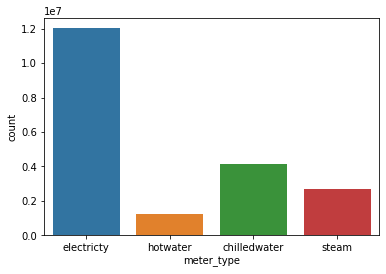

In [15]:
sns.countplot(x='meter_type',data=final_df)

### Observation
From the above count plot we can clearly see electricity meters are used more compared to the other meters.

In [16]:
final_df['primary_use'].value_counts()

Education                        8124766
Office                           4379290
Entertainment/public assembly    2254880
Lodging/residential              2130981
Public services                  1658858
Healthcare                        397992
Other                             242163
Parking                           213777
Manufacturing/industrial          124458
Food sales and service            114041
Retail                            112564
Warehouse/storage                 111838
Services                           96493
Technology/science                 76713
Utility                            55016
Religious worship                  31775
Name: primary_use, dtype: int64

<AxesSubplot:xlabel='primary_use', ylabel='count'>

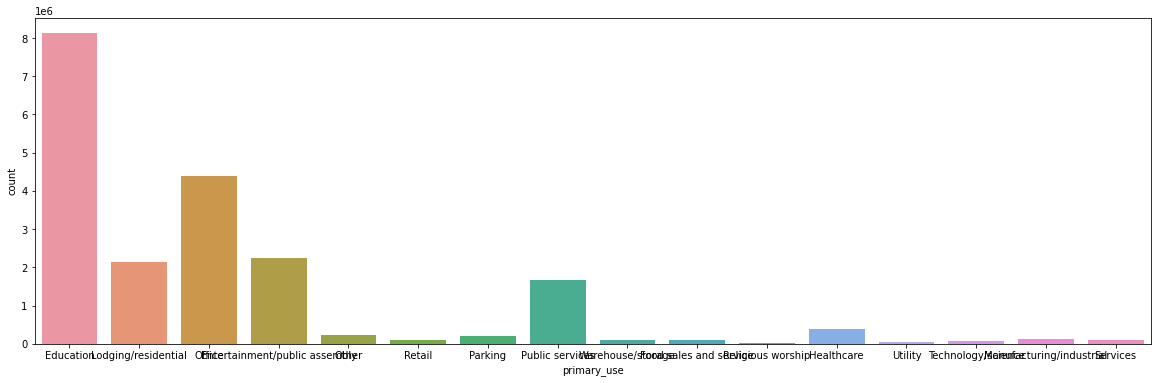

In [17]:
plt.figure(figsize=(20,6))
sns.countplot(x='primary_use',data=final_df)

We can observe data consits of buildings meter reading majorly belonging to Education,Office,Entertainment/pulic sector ,Lodging /Residential and Public services. While the other sectors are very less compared to these sectors.

<AxesSubplot:xlabel='site_id', ylabel='count'>

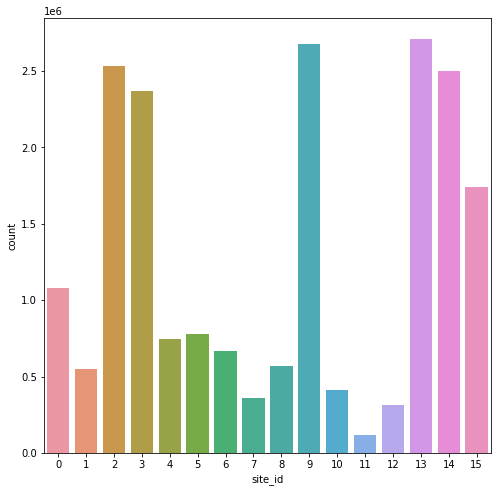

In [18]:
plt.figure(figsize=(8,8))
sns.countplot(x='site_id',data=final_df)

Building meter readings are taken from 16 sites as mentioned in the problem statement. Sites 2,3,9,13,15 and 14 contribute majorly to the meter readings 

C:\Users\ASUS\anaconda3\envs\ipl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


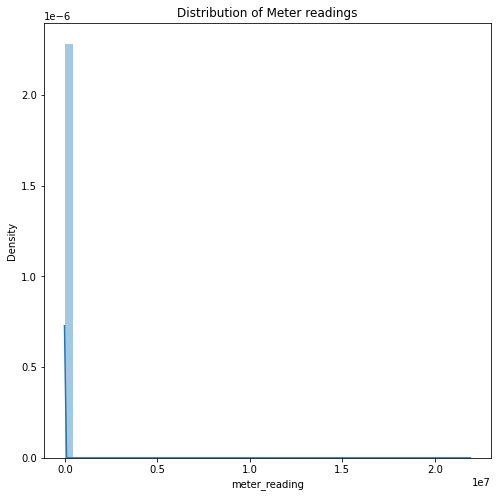

In [19]:
final_df['meter_reading'].describe()
plt.figure(figsize=(8,8))
sns.distplot(final_df['meter_reading'])
plt.xlabel('meter_reading')
plt.title('Distribution of Meter readings')
plt.show()

Can not interpret much information from this graph. Checking out the graph by converting the meter readings to logarthimic values.

In [20]:
final_df['log_meter_reading'] = np.log1p(final_df['meter_reading'])

C:\Users\ASUS\anaconda3\envs\ipl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


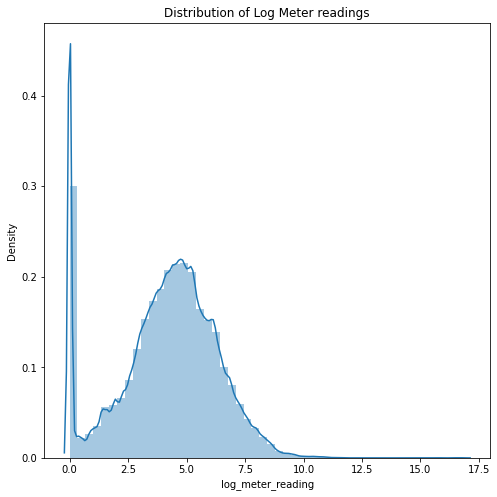

In [21]:
plt.figure(figsize=(8,8))
sns.distplot(final_df['log_meter_reading'])
plt.xlabel('log_meter_reading')
plt.title('Distribution of Log Meter readings')
plt.show()

From the above meter reading distribution (log) graph we can observe that there are a lot of zero value meter reading present. After conversion of meter reading to logarthimic values there is a good spread/variance of data.

Text(0.5, 1.0, 'Site ID having 0 meter reading')

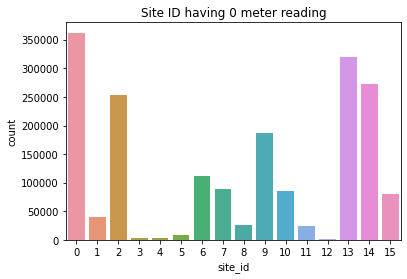

In [22]:
zero_val_reading = final_df[final_df['meter_reading']==0]
sns.countplot(x='site_id',data= zero_val_reading)
plt.title('Site ID having 0 meter reading')

We can see that meter reading having 0 is present around 9.28% in the data. It can be considered as a abnormal/outlier value. when considering site id, site id 0,2,13,14 and 9 have mostly '0' as their meter reading when compared to other site ids.

## Checking for nan values in data

In [23]:
final_df.isnull().sum()/len(final_df)*100

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            60.188531
floor_count           82.631315
air_temperature        0.030623
cloud_coverage        43.401776
dew_temperature        0.047924
precip_depth_1_hr     18.178475
sea_level_pressure     5.670259
wind_direction         6.750371
wind_speed             0.264245
meter_type             0.000000
log_meter_reading      0.000000
dtype: float64

### Observation
We can see more than 50% data is missing from year_built and floor_count features. We can consider removing these columns/features from the data.

In [24]:
#fill NaN values with the median values of the respective column
final_df['air_temperature'] = final_df['air_temperature'].fillna(final_df['air_temperature'].median())
final_df['cloud_coverage'] = final_df['cloud_coverage'].fillna(final_df['cloud_coverage'].median())
final_df['precip_depth_1_hr'] = final_df['precip_depth_1_hr'].fillna(final_df['precip_depth_1_hr'].median())
final_df['sea_level_pressure'] = final_df['sea_level_pressure'].fillna(final_df['sea_level_pressure'].median())
final_df['wind_direction'] = final_df['wind_direction'].fillna(final_df['wind_direction'].median())
final_df['dew_temperature'] = final_df['dew_temperature'].fillna(final_df['dew_temperature'].median())
final_df['wind_speed'] = final_df['wind_speed'].fillna(final_df['wind_speed'].median())

In [25]:
final_df.isnull().sum()/len(final_df)*100

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            60.188531
floor_count           82.631315
air_temperature        0.000000
cloud_coverage         0.000000
dew_temperature        0.000000
precip_depth_1_hr      0.000000
sea_level_pressure     0.000000
wind_direction         0.000000
wind_speed             0.000000
meter_type             0.000000
log_meter_reading      0.000000
dtype: float64

## Features using time data

In [26]:
final_df['timestamp'] = pd.to_datetime(final_df['timestamp'],format='%Y-%m-%d %H:%M')

In [27]:
final_df['month'] = final_df['timestamp'].dt.month
final_df['day'] = final_df['timestamp'].dt.day
final_df['hour'] = final_df['timestamp'].dt.hour
final_df['day_week'] = final_df['timestamp'].dt.dayofweek
final_df['day_of_week']=final_df['day_week'].map({0:'monday',1:'tuesday',2:'wednesday',3:'thursday',4:'friday',5:'saturday',6:'sunday'})
final_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,sea_level_pressure,wind_direction,wind_speed,meter_type,log_meter_reading,month,day,hour,day_week,day_of_week
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,...,1019.5,0.0,0.0,electricty,0.0,1,1,0,4,friday
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,...,1019.5,0.0,0.0,electricty,0.0,1,1,0,4,friday
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,...,1019.5,0.0,0.0,electricty,0.0,1,1,0,4,friday
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,...,1019.5,0.0,0.0,electricty,0.0,1,1,0,4,friday
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,...,1019.5,0.0,0.0,electricty,0.0,1,1,0,4,friday


C:\Users\ASUS\anaconda3\envs\ipl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


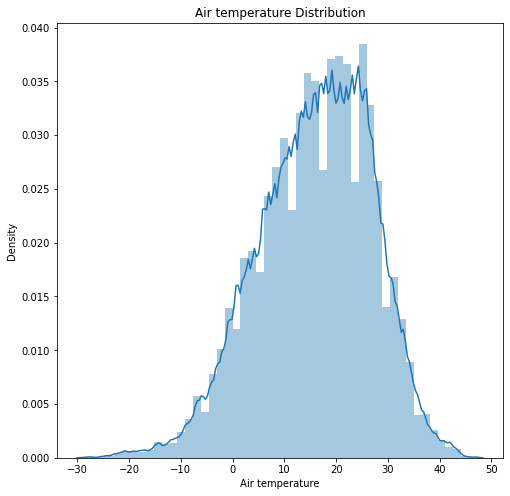

In [28]:
plt.figure(figsize=(8,8))
sns.distplot(final_df['air_temperature'])
plt.xlabel('Air temperature')
plt.title('Air temperature Distribution')
plt.show()

Distribution of Air temperature feature is quite similar to normal/gaussian distribution.

C:\Users\ASUS\anaconda3\envs\ipl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


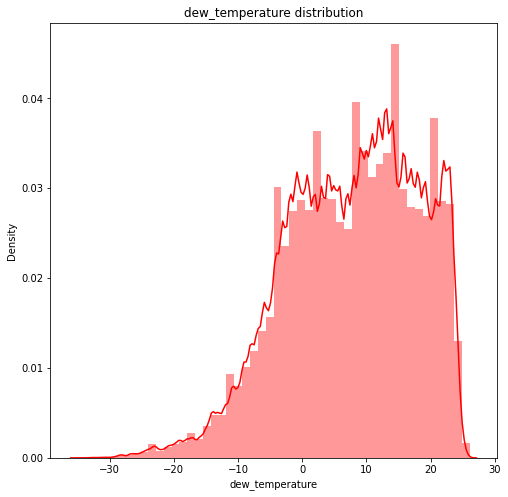

In [29]:
plt.figure(figsize=(8,8))
sns.distplot(final_df['dew_temperature'],color='red')
plt.xlabel('dew_temperature')
plt.title('dew_temperature distribution')
plt.show()

Distribution of Dew temperature is slightly left skewed in nature. From the distribution we can observe majority of values range from -10 to 25 degree celcius

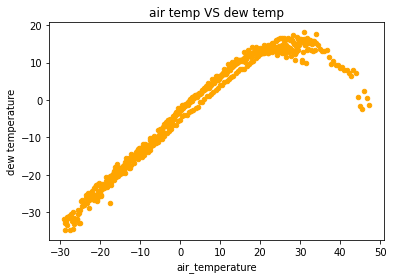

In [30]:
avg_air_dew = final_df.groupby(['air_temperature']).dew_temperature.mean().reset_index()
avg_air_dew.plot(kind='scatter',x='air_temperature',y='dew_temperature',color = 'orange')
plt.ylabel('dew temperature')
plt.title('air temp VS dew temp')
plt.show()

There is a positive correlation between air temperature and dew temperature. As Air temperature increases we can obsereve an increase  in dew temperature.

C:\Users\ASUS\anaconda3\envs\ipl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


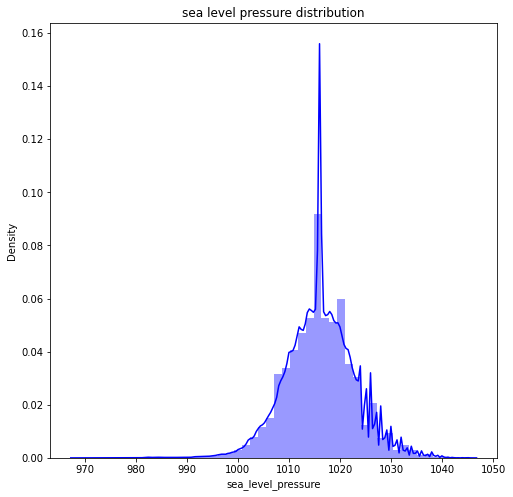

In [31]:
plt.figure(figsize=(8,8))
sns.distplot(final_df['sea_level_pressure'],color='blue')
plt.xlabel('sea_level_pressure')
plt.title('sea level pressure distribution')
plt.show()

Distribution of Sea level pressure feature is quite similar to normal/gaussian distribution.

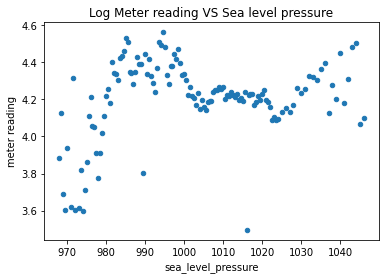

In [32]:
sea_level_meter = final_df.groupby(['sea_level_pressure']).log_meter_reading.mean().reset_index()
sea_level_meter.plot(kind='scatter',x='sea_level_pressure',y='log_meter_reading')
plt.ylabel('meter reading')
plt.title('Log Meter reading VS Sea level pressure')
plt.show()

In the above scatter plot we can observe some relation between sea level pressure and meter reading. As there is an increse in sea level from 970 to 985 there is a gradual increase in meter reading as well.

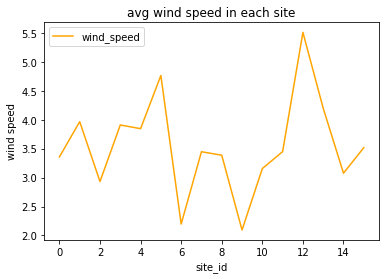

In [33]:
site_wind_speed = final_df.groupby(['site_id']).wind_speed.mean().reset_index()
site_wind_speed.plot(x='site_id',y='wind_speed',color = 'orange')
plt.ylabel('wind speed')
plt.title('avg wind speed in each site')
plt.show()

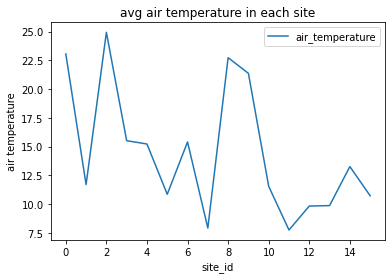

In [34]:
site_temperature = final_df.groupby(['site_id']).air_temperature.mean().reset_index()
site_temperature.plot(kind='line',x='site_id',y='air_temperature')
plt.ylabel('air temperature')
plt.title('avg air temperature in each site')
plt.show()

From the above two plots we can observe sites having cooler air temperatures have higher wind speeds compared to the sites having moderate temperatures.

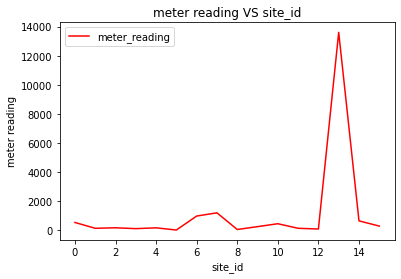

In [35]:
avg_meter_reading = final_df.groupby(['site_id']).meter_reading.mean().reset_index()
avg_meter_reading.plot(x='site_id',y='meter_reading',color ='red')
plt.xlabel('site_id')
plt.ylabel('meter reading')
plt.title('meter reading VS site_id')
plt.show()

The above plot indiccates there is a lot of energy consumed by buildings in site 13 when compared to other sites.

<AxesSubplot:xlabel='site_id', ylabel='log_meter_reading'>

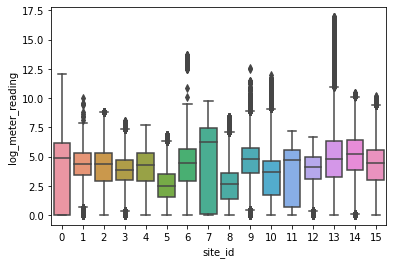

In [36]:
sns.boxplot(x='site_id',y='log_meter_reading',data=final_df) 

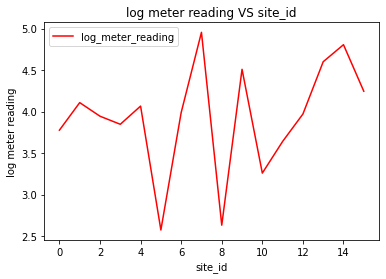

In [37]:
a = final_df.groupby(['site_id']).log_meter_reading.mean().reset_index()
a.plot(x='site_id',y='log_meter_reading',color ='red')
plt.xlabel('site_id')
plt.ylabel('log meter reading')
plt.title('log meter reading VS site_id')
plt.show()

The above graph shows the average meter reading of all the sites.  We can observe that average meter reading of site id 13 is greater compared to all other.

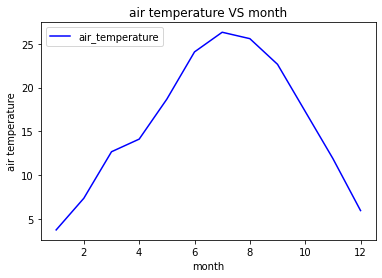

In [38]:
avg_air_temp = final_df.groupby(['month']).air_temperature.mean().reset_index()
avg_air_temp.plot(x='month',y='air_temperature',color='blue')
plt.ylabel('air temperature')
plt.title('air temperature VS month')
plt.show()

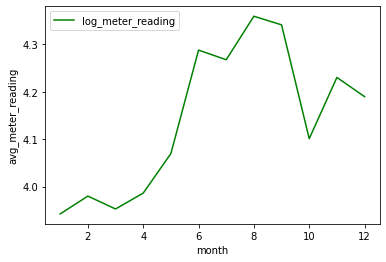

In [39]:
avg_meter_reading_month = final_df.groupby(['month']).log_meter_reading.mean().reset_index()
avg_meter_reading_month.plot(x='month',y='log_meter_reading',color ='green')
plt.ylabel('avg_meter_reading')
plt.show()

From the above two plots we can observe an increase in energy consumption during summers and decrease in energy consumption during winter period.

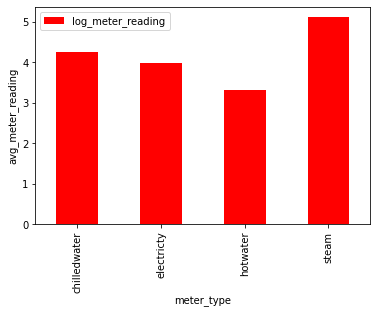

In [40]:
avg_meter_reading = final_df.groupby(['meter_type']).log_meter_reading.mean().reset_index()
avg_meter_reading.plot(kind = 'bar',x='meter_type',y='log_meter_reading',color ='red')
plt.ylabel('avg_meter_reading')
plt.show()

From the bar graph we can see that average energy consumed by steam is more compared to the other energy consumptions sources.

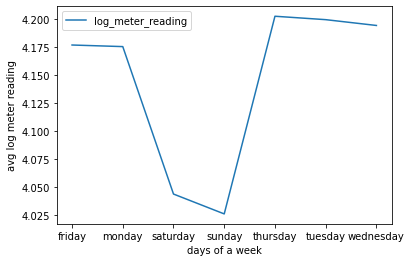

In [41]:
avg_meter_read_day=final_df.groupby(['day_of_week']).log_meter_reading.mean().reset_index()
avg_meter_read_day.plot(x='day_of_week',y='log_meter_reading')
plt.ylabel('avg log meter reading')
plt.xlabel('days of a week')
plt.show()

During weekends since people generally prefer outting rather than staying indoors, energy consumption on these days is less compared to other days.

C:\Users\ASUS\anaconda3\envs\ipl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


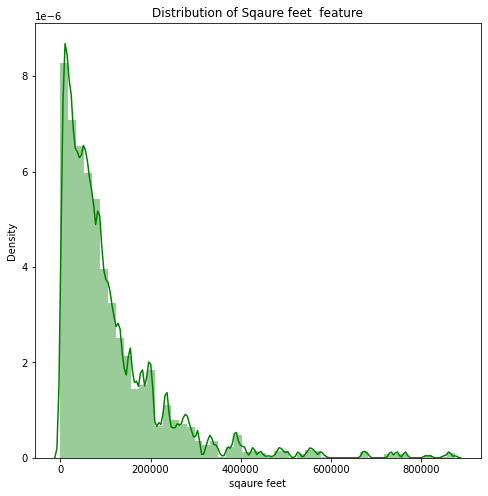

In [42]:
plt.figure(figsize=(8,8))
sns.distplot(final_df['square_feet'],color='g')
plt.xlabel('sqaure feet')
plt.title('Distribution of Sqaure feet  feature')
plt.show()

Distribution of Building Square feet is right skewed in nature. From the distribution we can observe majority of values range below 200k sq feet.

In [43]:
final_df['log_square_feet'] = np.log1p(final_df['square_feet'])

C:\Users\ASUS\anaconda3\envs\ipl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


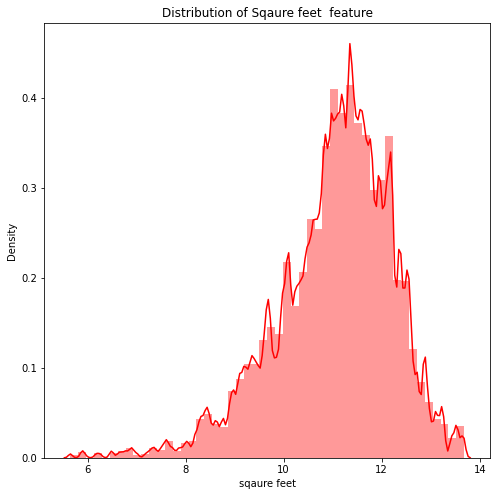

In [44]:
plt.figure(figsize=(8,8))
sns.distplot(final_df['log_square_feet'],color='r')
plt.xlabel('sqaure feet')
plt.title('Distribution of Sqaure feet  feature')
plt.show()

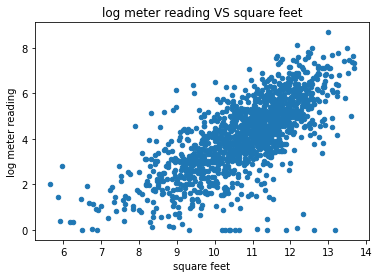

In [45]:
square_feet = final_df.groupby(['log_square_feet']).log_meter_reading.median().reset_index()
square_feet.plot(kind ='scatter', x='log_square_feet',y='log_meter_reading')
plt.xlabel('square feet')
plt.ylabel('log meter reading')
plt.title('log meter reading VS square feet')
plt.show()

When converting the square feet to logarthimic values we observe a positive relation between log meter readings and the square feet features. We can assume more the square feet more is the energy consumption.

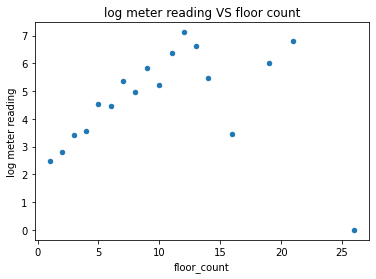

In [46]:
floor_count = final_df.groupby(['floor_count']).log_meter_reading.median().reset_index()
floor_count.plot(kind ='scatter', x='floor_count',y='log_meter_reading')
plt.xlabel('floor_count')
plt.ylabel('log meter reading')
plt.title('log meter reading VS floor count')
plt.show()

We observe a positive relation between log meter readings and floor count features. We can assume more the floor count more is the energy consumption of the building.

<AxesSubplot:>

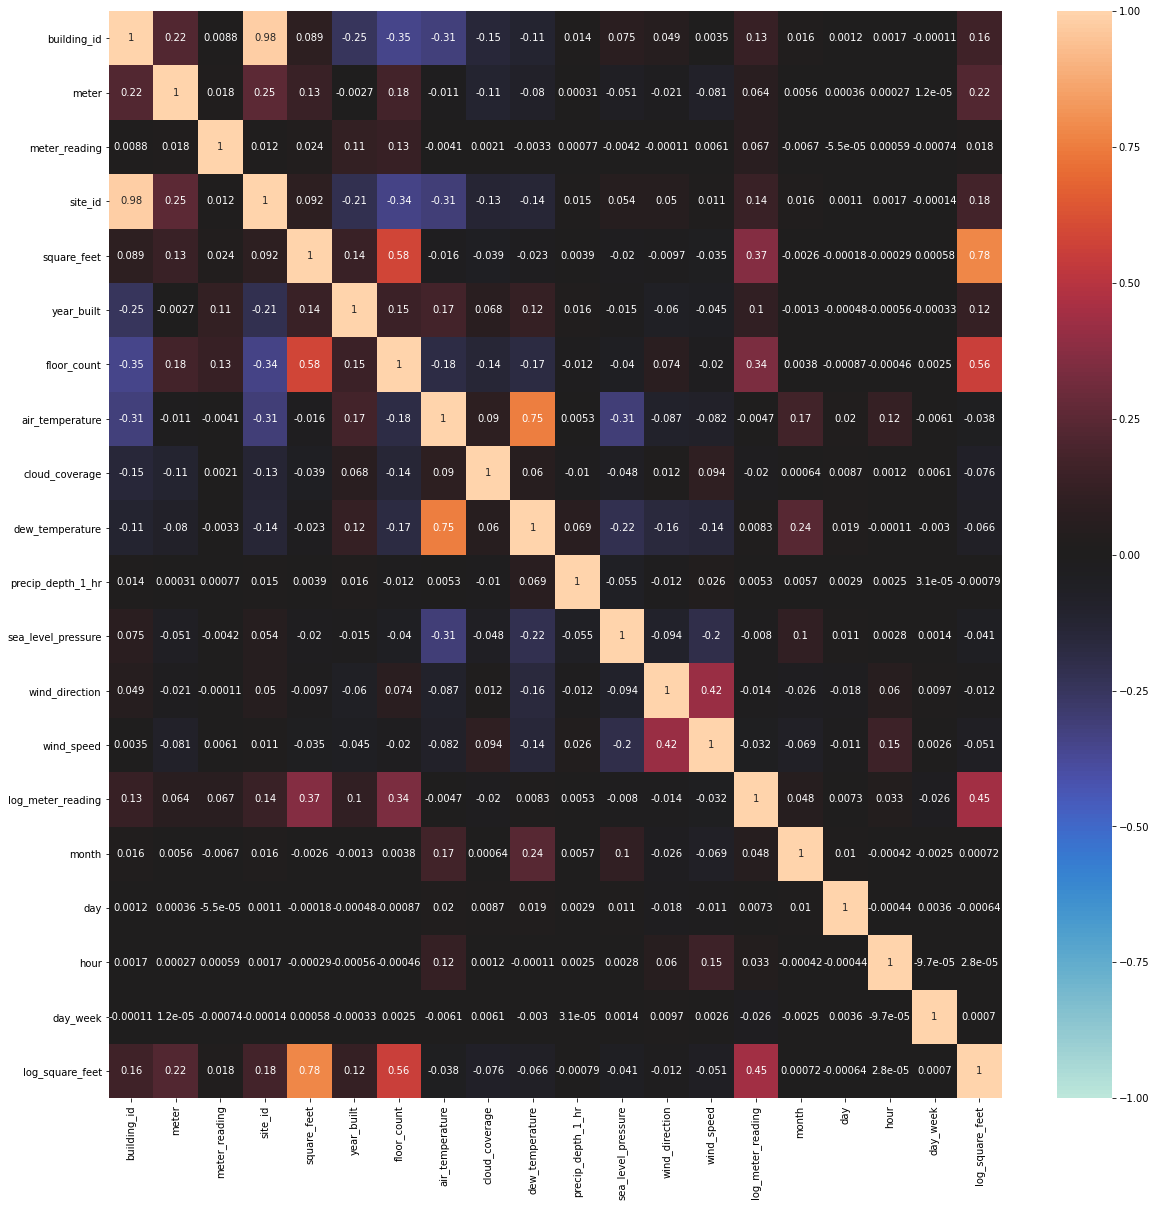

In [47]:
df_corr = final_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(df_corr,annot=True,vmin=-1,vmax=1,center=0)

Here is a correlation heatmap of the data. Features which are positively correlated to each other tend to have a value closer to 1 where as features which are negatively correlated to each other tend to have a value closer to -1. If there is not any relation between features than value is 0. Here we can observe the target feature- log_meter_reading tends to be positively correlated to log_square_feet, square_feet and floor_count features.

### Outlier Detection

<AxesSubplot:ylabel='meter_reading'>

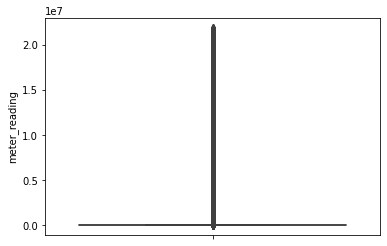

In [48]:
sns.boxplot(y='meter_reading',data=final_df)

In [49]:
for i in range(0,101,10):
    print('{} percentile meter reading :{}'.format(i,np.percentile(final_df['meter_reading'],i)))

0 percentile meter reading :0.0
10 percentile meter reading :0.31690001487731934
20 percentile meter reading :11.0
30 percentile meter reading :26.260000228881836
40 percentile meter reading :47.27000045776367
50 percentile meter reading :78.75
60 percentile meter reading :125.18299865722656
70 percentile meter reading :201.47999572753906
80 percentile meter reading :369.9729919433594
90 percentile meter reading :801.5599975585938
100 percentile meter reading :21904700.0


In [50]:
for i in range(90,101,1):
    print('{} percentile meter reading: {}'.format(i,np.percentile(final_df['meter_reading'],i)))

90 percentile meter reading: 801.5599975585938
91 percentile meter reading: 895.0
92 percentile meter reading: 1000.0
93 percentile meter reading: 1143.6700439453125
94 percentile meter reading: 1332.47998046875
95 percentile meter reading: 1579.3800048828125
96 percentile meter reading: 1939.1400146484375
97 percentile meter reading: 2499.81005859375
98 percentile meter reading: 3417.1093066406056
99 percentile meter reading: 5453.7362304688395
100 percentile meter reading: 21904700.0


In [51]:
lst=[99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
for i in lst:
    print('{} percentile meter reading :{}'.format(i,np.percentile(final_df['meter_reading'],i)))

99.0 percentile meter reading :5453.7362304688395
99.1 percentile meter reading :5803.871154296861
99.2 percentile meter reading :6281.25
99.3 percentile meter reading :6968.75
99.4 percentile meter reading :7921.8798828125
99.5 percentile meter reading :9429.6904296875
99.6 percentile meter reading :11500.0
99.7 percentile meter reading :14390.599609375
99.8 percentile meter reading :20819.58839062415
99.9 percentile meter reading :38789.1015625
100 percentile meter reading :21904700.0


While observing the meter readings of the data it can be found that there are some abnormal readings. The meter readings are fine/considerable till 99.9 percentile but after that we can observe big spike in meter readings. We can consider meter readings above the 99.9 percetiles as outliers.

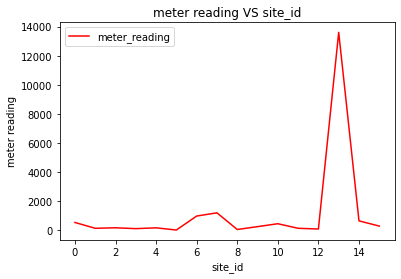

In [52]:
avg_meter_reading = final_df.groupby(['site_id']).meter_reading.mean().reset_index()
avg_meter_reading.plot(x='site_id',y='meter_reading',color ='red')
plt.xlabel('site_id')
plt.ylabel('meter reading')
plt.title('meter reading VS site_id')
plt.show()

In [53]:
site_13 = final_df[final_df['site_id']==13]
for i in range(10,101,10):
    print('{} percentile meter reading of site 13 :{}'.format(i,np.percentile(site_13['meter_reading'],i)))

10 percentile meter reading of site 13 :0.0
20 percentile meter reading of site 13 :14.32759952545166
30 percentile meter reading of site 13 :36.650001525878906
40 percentile meter reading of site 13 :68.19000244140625
50 percentile meter reading of site 13 :119.4749984741211
60 percentile meter reading of site 13 :198.05599975585938
70 percentile meter reading of site 13 :382.5140075683594
80 percentile meter reading of site 13 :820.31201171875
90 percentile meter reading of site 13 :2125.0
100 percentile meter reading of site 13 :21904700.0


In [54]:
for i in range(90,101,1):
    print('{} percentile meter reading of site 13 :{}'.format(i,np.percentile(site_13['meter_reading'],i)))

90 percentile meter reading of site 13 :2125.0
91 percentile meter reading of site 13 :2437.5
92 percentile meter reading of site 13 :2768.1475000000023
93 percentile meter reading of site 13 :3187.5
94 percentile meter reading of site 13 :3826.169921875
95 percentile meter reading of site 13 :4675.77978515625
96 percentile meter reading of site 13 :5824.22021484375
97 percentile meter reading of site 13 :8171.8798828125
98 percentile meter reading of site 13 :13125.0
99 percentile meter reading of site 13 :28091.910000000615
100 percentile meter reading of site 13 :21904700.0


In [55]:
lst=[99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
for i in lst:
    print('{} percentile meter reading of site 13 :{}'.format(i,np.percentile(site_13['meter_reading'],i)))

99.0 percentile meter reading of site 13 :28091.910000000615
99.1 percentile meter reading of site 13 :31062.5
99.2 percentile meter reading of site 13 :33468.80078125
99.3 percentile meter reading of site 13 :36937.5
99.4 percentile meter reading of site 13 :40582.52874218943
99.5 percentile meter reading of site 13 :45812.5
99.6 percentile meter reading of site 13 :51593.80078125
99.7 percentile meter reading of site 13 :60750.0
99.8 percentile meter reading of site 13 :88896.28200000012
99.9 percentile meter reading of site 13 :3243615.6100009196
100 percentile meter reading of site 13 :21904700.0


While observing the average meter readings of all the sites it is noticable that avg meter readings of the site id 13 are found to have some abnormal readings. The meter readings of site_id 13 are fine/considerable till 99.8 percentile but after that we can observe big spike in meter readings. We can consider meter readings above the 99.8 percetiles as outliers in the case of site_id 13.

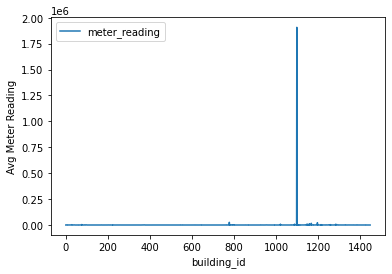

In [56]:
build_data_out = final_df.groupby(['building_id']).meter_reading.mean().reset_index()
build_data_out.plot(kind='line',x='building_id',y='meter_reading')
plt.ylabel('Avg Meter Reading')
plt.show()

Text(0, 0.5, 'meter reading')

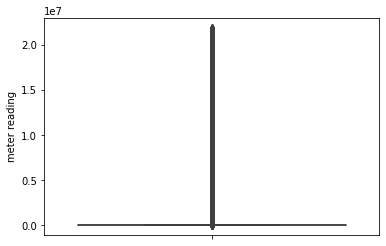

In [57]:
build_1099 =final_df[final_df['building_id']==1099]
sns.boxplot(y='meter_reading',data=build_1099)
plt.ylabel('meter reading')

In [58]:
for i in range(0,101,10):
    print('{} percentile meter reading of building id 1099 :{}'.format(i,np.percentile(build_1099['meter_reading'],i)))

0 percentile meter reading of building id 1099 :144.0
10 percentile meter reading of building id 1099 :370.9198028564453
20 percentile meter reading of building id 1099 :475.09539184570315
30 percentile meter reading of building id 1099 :576.0
40 percentile meter reading of building id 1099 :737.6042114257813
50 percentile meter reading of building id 1099 :985.6969909667969
60 percentile meter reading of building id 1099 :1440.0
70 percentile meter reading of building id 1099 :3504.0
80 percentile meter reading of building id 1099 :12984.0
90 percentile meter reading of building id 1099 :7358125.000000004
100 percentile meter reading of building id 1099 :21904700.0


We can observe that the meter readings of the building id 1099 are abnormal and consider it as a outlier. We can remove the data belonging to building ID 1099.

In [59]:
lst_indices = list(final_df[final_df['building_id']==1099].index)
# Dropping data points where building Id = 1099
final_df.drop(lst_indices,axis=0,inplace=True)
final_df.shape

(20108041, 24)

In [60]:
final_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,wind_direction,wind_speed,meter_type,log_meter_reading,month,day,hour,day_week,day_of_week,log_square_feet
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,...,0.0,0.0,electricty,0.0,1,1,0,4,friday,8.913685
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,...,0.0,0.0,electricty,0.0,1,1,0,4,friday,7.908755
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,...,0.0,0.0,electricty,0.0,1,1,0,4,friday,8.589886
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,...,0.0,0.0,electricty,0.0,1,1,0,4,friday,10.072639
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,...,0.0,0.0,electricty,0.0,1,1,0,4,friday,11.666573


In the below cell we are dropping all zero value readings for electric meter type as it is a abnormal value to be considered

In [61]:
# Dropping meter reading 0 for electric meters
zero_val = list(final_df[final_df['meter']==0][final_df['meter_reading']==0.0].index)
final_df.drop(zero_val,inplace=True,axis=0)
final_df.shape

C:\Users\ASUS\anaconda3\envs\ipl\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(19578820, 24)

<AxesSubplot:ylabel='wind_speed'>

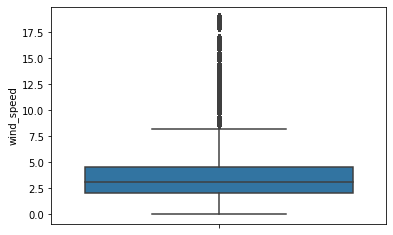

In [62]:
sns.boxplot(y='wind_speed',data=final_df)

In [63]:
for i in range(0,101,10):
    print('{} percentile of wind speed :{}'.format(i,np.percentile(final_df['wind_speed'],i)))

0 percentile of wind speed :0.0
10 percentile of wind speed :0.0
20 percentile of wind speed :1.5
30 percentile of wind speed :2.099609375
40 percentile of wind speed :2.599609375
50 percentile of wind speed :3.099609375
60 percentile of wind speed :3.599609375
70 percentile of wind speed :4.1015625
80 percentile of wind speed :5.1015625
90 percentile of wind speed :6.19921875
100 percentile of wind speed :19.0


In [64]:
for i in range(90,101,1):
    print('{} percentile of wind speed :{}'.format(i,np.percentile(final_df['wind_speed'],i)))

90 percentile of wind speed :6.19921875
91 percentile of wind speed :6.69921875
92 percentile of wind speed :6.69921875
93 percentile of wind speed :7.19921875
94 percentile of wind speed :7.19921875
95 percentile of wind speed :7.69921875
96 percentile of wind speed :7.69921875
97 percentile of wind speed :8.203125
98 percentile of wind speed :8.796875
99 percentile of wind speed :10.0
100 percentile of wind speed :19.0


In [65]:
lst=[99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
for i in lst:
    print('{} percentile of wind speed :{}'.format(i,np.percentile(final_df['wind_speed'],i)))

99.0 percentile of wind speed :10.0
99.1 percentile of wind speed :10.296875
99.2 percentile of wind speed :10.296875
99.3 percentile of wind speed :10.796875
99.4 percentile of wind speed :10.796875
99.5 percentile of wind speed :11.0
99.6 percentile of wind speed :11.296875
99.7 percentile of wind speed :11.796875
99.8 percentile of wind speed :12.3984375
99.9 percentile of wind speed :13.3984375
100 percentile of wind speed :19.0


<AxesSubplot:xlabel='site_id', ylabel='wind_speed'>

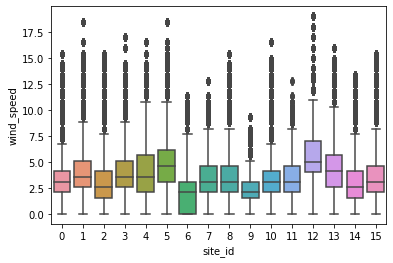

In [66]:
sns.boxplot(x='site_id',y='wind_speed',data=final_df)

In the case of wind speed from the above box plot and percentile observation we can see 99% of data points have wind speed less than 10. Even when plotting boxplot for wind speed for each site_id we can observe 75% wind speed of each site id is less than 10. Wind speed range from 0 to 19. These values seem to be pretty normal and there isn't such abnormilty in wind speed category.

<AxesSubplot:ylabel='air_temperature'>

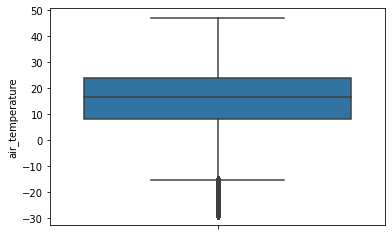

In [67]:
sns.boxplot(y='air_temperature',data=final_df)

In [68]:
for i in range(0,101,10):
    print('{} percentile of air temperature :{}'.format(i,np.percentile(final_df['air_temperature'],i)))

0 percentile of air temperature :-28.90625
10 percentile of air temperature :1.099609375
20 percentile of air temperature :6.30078125
30 percentile of air temperature :10.1015625
40 percentile of air temperature :13.8984375
50 percentile of air temperature :16.703125
60 percentile of air temperature :19.40625
70 percentile of air temperature :22.796875
80 percentile of air temperature :25.59375
90 percentile of air temperature :29.40625
100 percentile of air temperature :47.1875


In [69]:
for i in range(0,10,1):
    print('{} percentile of air temperature :{}'.format(i,np.percentile(final_df['air_temperature'],i)))

0 percentile of air temperature :-28.90625
1 percentile of air temperature :-11.703125
2 percentile of air temperature :-7.80078125
3 percentile of air temperature :-6.1015625
4 percentile of air temperature :-4.3984375
5 percentile of air temperature :-2.80078125
6 percentile of air temperature :-1.7001953125
7 percentile of air temperature :-1.099609375
8 percentile of air temperature :0.0
9 percentile of air temperature :0.60009765625


Wind speeds in this data range from -29°C to almost 50°C which seem to be fine. 

In [70]:
final_df.to_csv('final_data.csv')